## Question 3

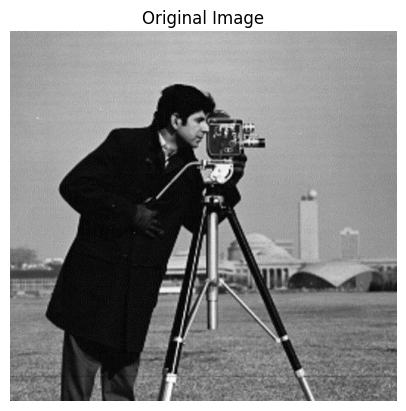

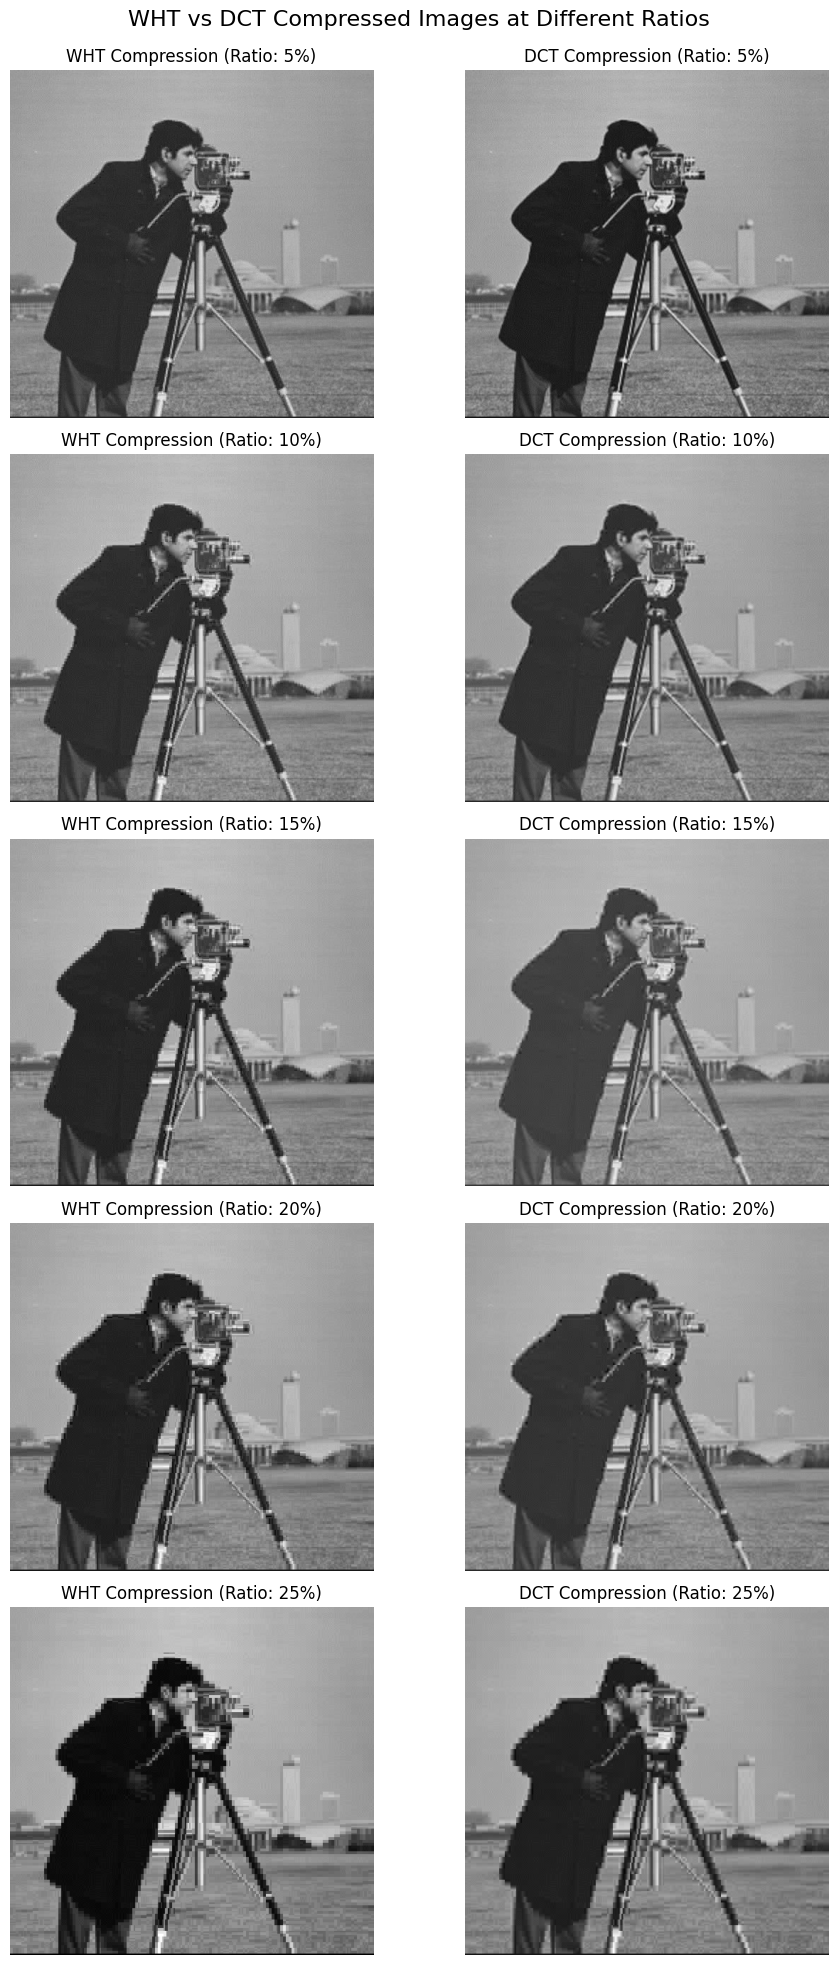

,Ratio,WHT_MSE,WHT_PSNR,WHT_SSIM,DCT_MSE,DCT_PSNR,DCT_SSIM
0,5,0.001399,28.541886,0.959120,0.001108,29.552790,0.974540
1,10,0.002148,26.680216,0.917958,0.001623,27.897143,0.936990
2,15,0.002814,25.506035,0.887582,0.002203,26.569549,0.905004
3,20,0.003434,24.641524,0.858834,0.002781,25.558190,0.877347
4,25,0.004397,23.568252,0.822654,0.003902,24.086957,0.833458


In [15]:
import numpy as np
import cv2
from scipy.fftpack import dct, idct
from scipy.linalg import hadamard
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Load the image
image_path = 'cameraman.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]

# Display the image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Walsh-Hadamard Transform functions
def wht_2d(block):
    N = block.shape[0]
    H = hadamard(N)
    return np.dot(np.dot(H, block), H)

def iwht_2d(block):
    N = block.shape[0]
    H = hadamard(N)
    return np.dot(np.dot(H, block), H) / (N ** 2)

# DCT functions
def dct_2d(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct_2d(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Compression and Reconstruction
def compress_image(image, block_size, transform, inverse_transform, ratio):
    height, width = image.shape
    compressed = np.zeros_like(image)

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            if i + block_size <= height and j + block_size <= width:
                block = image[i:i+block_size, j:j+block_size]
                transformed = transform(block)
                ravel_transformed = transformed.flatten()
                k = int(len(ravel_transformed) / ratio)
                indices = np.argsort(np.abs(ravel_transformed))[-k:]
                compressed_block = np.zeros_like(ravel_transformed)
                compressed_block[indices] = ravel_transformed[indices]
                compressed_block = compressed_block.reshape(block.shape)
                compressed[i:i+block_size, j:j+block_size] = inverse_transform(compressed_block)

    return compressed

# Different compression ratios
ratios = [5, 10, 15, 20, 25]

wht_compressed_images = [compress_image(image, 8, wht_2d, iwht_2d, ratio) for ratio in ratios]
dct_compressed_images = [compress_image(image, 8, dct_2d, idct_2d, ratio) for ratio in ratios]

# Evaluation Metrics
def compute_metrics(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    psnr_value = psnr(original, compressed)
    ssim_value = ssim(original, compressed)
    return mse, psnr_value, ssim_value

metrics_wht = [compute_metrics(image, img) for img in wht_compressed_images]
metrics_dct = [compute_metrics(image, img) for img in dct_compressed_images]

# Plotting the results
fig, axes = plt.subplots(len(ratios), 2, figsize=(10, 20))
fig.suptitle('WHT vs DCT Compressed Images at Different Ratios', fontsize=16)

for i, ratio in enumerate(ratios):
    axes[i, 0].imshow(wht_compressed_images[i], cmap='gray')
    axes[i, 0].set_title(f'WHT Compression (Ratio: {ratio}%)')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(dct_compressed_images[i], cmap='gray')
    axes[i, 1].set_title(f'DCT Compression (Ratio: {ratio}%)')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# Results
results = []
for i, ratio in enumerate(ratios):
    results.append({
        'Ratio': ratio,
        'WHT_MSE': metrics_wht[i][0],
        'WHT_PSNR': metrics_wht[i][1],
        'WHT_SSIM': metrics_wht[i][2],
        'DCT_MSE': metrics_dct[i][0],
        'DCT_PSNR': metrics_dct[i][1],
        'DCT_SSIM': metrics_dct[i][2],
    })

import pandas as pd
results_df = pd.DataFrame(results)
results_df


In [7]:
from decimal import Decimal

class ArithmeticEncoding:
    """
    ArithmeticEncoding is a class for building arithmetic encoding.
    """

    def __init__(self, frequency_table):
        self.probability_table = self.get_probability_table(frequency_table)

    def get_probability_table(self, frequency_table):
        """
        Calculates the probability table out of the frequency table.
        """
        total_frequency = sum(list(frequency_table.values()))

        probability_table = {}
        for key, value in frequency_table.items():
            probability_table[key] = value/total_frequency

        return probability_table

    def get_encoded_value(self, encoder):
        """
        After encoding the entire message, this method returns the single value that represents the entire message.
        """
        last_stage = list(encoder[-1].values())
        last_stage_values = []
        for sublist in last_stage:
            for element in sublist:
                last_stage_values.append(element)

        last_stage_min = min(last_stage_values)
        last_stage_max = max(last_stage_values)

        return (last_stage_min + last_stage_max)/2

    def process_stage(self, probability_table, stage_min, stage_max):
        """
        Processing a stage in the encoding/decoding process.
        """
        stage_probs = {}
        stage_domain = stage_max - stage_min
        for term_idx in range(len(probability_table.items())):
            term = list(probability_table.keys())[term_idx]
            term_prob = Decimal(probability_table[term])
            cum_prob = term_prob * stage_domain + stage_min
            stage_probs[term] = [stage_min, cum_prob]
            stage_min = cum_prob
        return stage_probs

    def encode(self, msg, probability_table):
        """
        Encodes a message.
        """

        encoder = []

        stage_min = Decimal(0.0)
        stage_max = Decimal(1.0)

        for msg_term_idx in range(len(msg)):
            stage_probs = self.process_stage(probability_table, stage_min, stage_max)

            msg_term = msg[msg_term_idx]
            stage_min = stage_probs[msg_term][0]
            stage_max = stage_probs[msg_term][1]

            encoder.append(stage_probs)

        stage_probs = self.process_stage(probability_table, stage_min, stage_max)
        encoder.append(stage_probs)

        encoded_msg = self.get_encoded_value(encoder)

        return encoder, encoded_msg

    def decode(self, encoded_msg, msg_length, probability_table):
        """
        Decodes a message.
        """

        decoder = []
        decoded_msg = ""

        stage_min = Decimal(0.0)
        stage_max = Decimal(1.0)

        for idx in range(msg_length):
            stage_probs = self.process_stage(probability_table, stage_min, stage_max)

            for msg_term, value in stage_probs.items():
                if encoded_msg >= value[0] and encoded_msg <= value[1]:
                    break

            decoded_msg = decoded_msg + msg_term
            stage_min = stage_probs[msg_term][0]
            stage_max = stage_probs[msg_term][1]

            decoder.append(stage_probs)

        stage_probs = self.process_stage(probability_table, stage_min, stage_max)
        decoder.append(stage_probs)

        return decoder, decoded_msg

In [8]:
# Compression and Reconstruction
def compress_image_arithmetic_encoding(image, block_size, transform, inverse_transform, ratio):
    height, width = image.shape
    compressed = np.zeros_like(image)
    # quantization_matrix = np.ones((block_size, block_size)) * (ratio / 100)

    frequency_table = {i: value for i, value in enumerate(np.bincount(image.flatten()))}
    ae = ArithmeticEncoding(frequency_table)

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            if i + block_size <= height and j + block_size <= width:
                block = image[i:i+block_size, j:j+block_size]
                transformed = transform(block)
                print(f'{transformed=}')
                # quantized = np.round(transformed / quantization_matrix) * quantization_matrix
                # print(f'{quantized.shape=}')
                encoder, encoded_msg = ae.encode(quantized.flatten(), ae.probability_table)
                print(f'{encoded_msg=}')
                decoder, decoded_msg = ae.decode(encoded_msg, block_size**2, ae.probability_table)
                print(f'{decoded_msg=}')
                print(f'{decoded_msg == quantized.flatten()=}')
                decoded_quantized = decoded_msg.reshape(block_size, block_size)
                compressed[i:i+block_size, j:j+block_size] = inverse_transform(decoded_quantized)

    return compressed

compress_image_arithmetic_encoding(image, 8, dct_2d, idct_2d, 16)

transformed=array([[ 1.24412500e+03,  8.88513564e-02, -1.93182310e+00,
         4.11043846e+00, -3.75000000e-01,  1.80107339e-01,
        -4.17503896e-01, -3.55615537e-01],
       [ 9.27924909e+00,  9.20261140e+00, -3.61231475e+00,
         3.08134454e-01,  2.87775332e+00,  1.68442331e-01,
        -3.30472227e-01, -2.08300548e-01],
       [ 4.63931182e-01, -3.16651839e-01, -7.90425234e+00,
        -5.76133318e-01,  6.76495125e-02, -3.84959975e-01,
        -2.13388348e-01,  4.08003734e-01],
       [ 4.06688900e+00, -5.65443126e+00, -2.94427861e+00,
        -1.18498368e+01,  4.45199833e-02, -2.86620237e-01,
         4.61558478e-01, -3.36155800e-01],
       [ 6.37500000e+00, -1.78120101e-01,  1.63320371e-01,
         8.07915577e-01,  3.75000000e-01,  3.27224406e-01,
         6.76495125e-02,  1.44809664e-01],
       [ 2.81615734e+00,  8.61557997e-02,  6.87994144e+00,
         8.13279715e+00,  3.95368398e-03, -7.99881943e-02,
         2.74702530e-01,  1.73995870e-01],
       [-5.73942661e+0

NameError: name 'quantized' is not defined

## Question 4

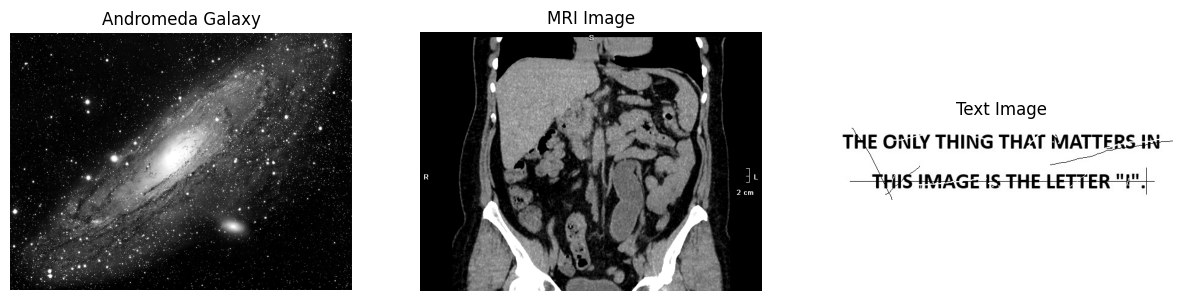

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the images
andromeda_image_path = 'andromeda-galaxy.png'
mri_image_path = 'mri.png'
text_image_path = 'text.jpg'

andromeda_image = cv2.imread(andromeda_image_path, cv2.IMREAD_GRAYSCALE)
mri_image = cv2.imread(mri_image_path, cv2.IMREAD_GRAYSCALE)
text_image = cv2.imread(text_image_path)

# Display the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(andromeda_image, cmap='gray')
plt.title('Andromeda Galaxy')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mri_image, cmap='gray')
plt.title('MRI Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(text_image, cv2.COLOR_BGR2RGB))
plt.title('Text Image')
plt.axis('off')

plt.show()


In [10]:
def erode(image, kernel):
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if np.all(padded_image[i:i+k_h, j:j+k_w] == kernel):
                output_image[i, j] = 1
    return output_image

def dilate(image, kernel):
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if np.any(padded_image[i:i+k_h, j:j+k_w] == kernel):
                output_image[i, j] = 1
    return output_image

def open_image(image, kernel):
    return dilate(erode(image, kernel), kernel)

def close_image(image, kernel):
    return erode(dilate(image, kernel), kernel)

# Structuring element (3x3 square)
kernel = np.ones((3, 3), dtype=np.uint8)

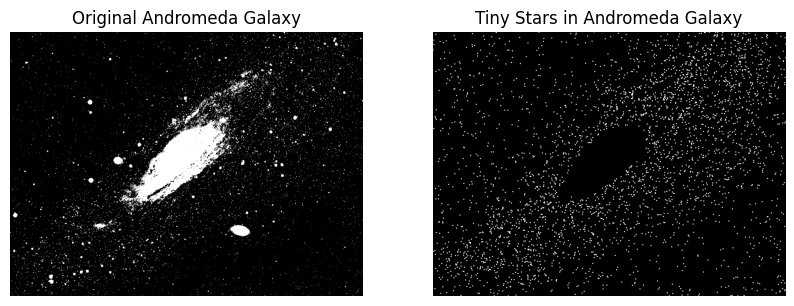

In [11]:
# Threshold the image to binarize it
_, andromeda_binary = cv2.threshold(andromeda_image, 127, 1, cv2.THRESH_BINARY)

# Structuring element (3x3 square)
kernel = np.array([[0, 0, 0],
                   [0, 1, 0],
                   [0, 0, 0]], dtype=np.uint8)

# Perform erosion to remove larger stars
eroded_andromeda = erode(andromeda_binary, kernel)

kernel = np.ones(shape=(3, 3), dtype=np.uint8)

# Perform dilation to restore tiny stars
dilated_andromeda = dilate(eroded_andromeda, kernel)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(andromeda_binary, cmap='gray', vmin=0, vmax=1)
plt.title('Original Andromeda Galaxy')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dilated_andromeda, cmap='gray', vmin=0, vmax=1)
plt.title('Tiny Stars in Andromeda Galaxy')
plt.axis('off')

plt.show()

In [12]:
# Helper function to get neighbors
def get_neighbors(x, y, shape):
    neighbors = []
    if x > 0: neighbors.append((x-1, y))
    if y > 0: neighbors.append((x, y-1))
    if x < shape[0] - 1: neighbors.append((x+1, y))
    if y < shape[1] - 1: neighbors.append((x, y+1))
    return neighbors

# Connected Components Labeling
def connected_components(binary_image):
    height, width = binary_image.shape
    labels = np.zeros((height, width), dtype=np.int32)
    label = 1
    equivalences = {}

    for i in range(height):
        for j in range(width):
            if binary_image[i, j] == 0:
                continue
            neighbors = [(i-1, j), (i, j-1)]
            neighbor_labels = [labels[x, y] for x, y in neighbors if x >= 0 and y >= 0 and labels[x, y] > 0]

            if not neighbor_labels:
                labels[i, j] = label
                equivalences[label] = {label}
                label += 1
            else:
                min_label = min(neighbor_labels)
                labels[i, j] = min_label
                for neighbor_label in neighbor_labels:
                    equivalences[neighbor_label].update(neighbor_labels)
                    equivalences[neighbor_label].add(min_label)

    new_labels = {}
    label = 1
    for i in range(height):
        for j in range(width):
            if labels[i, j] > 0:
                root_label = min(equivalences[labels[i, j]])
                if root_label not in new_labels:
                    new_labels[root_label] = label
                    label += 1
                labels[i, j] = new_labels[root_label]

    return labels, label - 1

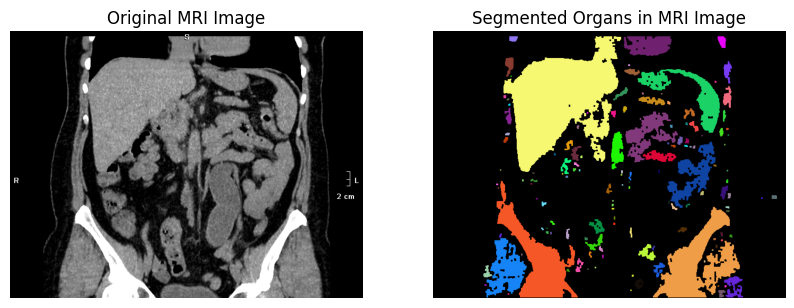

In [13]:
# Threshold the image to binarize it
_, mri_binary = cv2.threshold(mri_image, 127, 1, cv2.THRESH_BINARY)

# Perform morphological operations to separate organs
closed_mri = close_image(mri_binary, kernel)
opened_mri = open_image(closed_mri, kernel)

# Label the segmented organs
num_labels, labels = cv2.connectedComponents(opened_mri)

# Create a color map to display the segmented organs distinctly
color_map = np.zeros((*labels.shape, 3), dtype=np.uint8)
for label in range(1, num_labels):
    color = np.random.randint(0, 255, size=3)
    color_map[labels == label] = color

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mri_image, cmap='gray')
plt.title('Original MRI Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(color_map)
plt.title('Segmented Organs in MRI Image')
plt.axis('off')

plt.show()

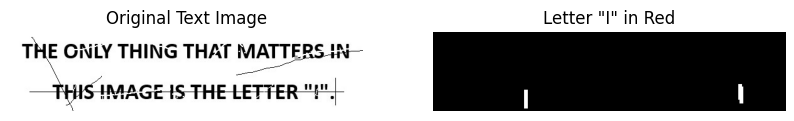

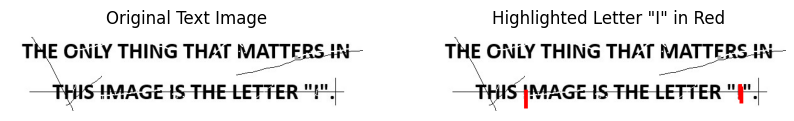

In [14]:
# Convert the image to grayscale and binarize it
gray_text = cv2.cvtColor(text_image, cv2.COLOR_BGR2GRAY)
_, binary_text = cv2.threshold(gray_text, 127, 1, cv2.THRESH_BINARY_INV)

# Structuring element (3x3 square)
kernel = np.ones((2, 2), dtype=np.uint8)
text_img_opening = open_image(binary_text, kernel)
kernel = np.ones((4, 4), dtype=np.uint8)
text_img_dilated = dilate(text_img_opening, kernel)

# Define a kernel to match the letter "I"
kernel_I = np.array([[0, 1, 1, 1, 1, 1, 0]]*2, dtype=np.uint8)

# Perform erosion to find the letter "I"
eroded_text = erode(text_img_dilated, kernel_I)
kernel_I = np.ones((25, 6), dtype=np.uint8)
dilated_text = dilate(eroded_text, kernel_I)

# Display the result

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(text_image, cmap='gray')
plt.title('Original Text Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dilated_text, cmap='gray', vmin=0, vmax=1)
plt.title('Letter "I" in Red')
plt.axis('off')

plt.show()

# Highlight the letter "I" in red
highlighted_text = text_image.copy()
highlighted_text[dilated_text == 1] = [0, 0, 255]

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(text_image, cv2.COLOR_BGR2RGB))
plt.title('Original Text Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(highlighted_text, cv2.COLOR_BGR2RGB))
plt.title('Highlighted Letter "I" in Red')
plt.axis('off')

plt.show()